# Mapa Litoestratigráfico Preditivo - Diamantina (MG)

##### Trabalho de Conclusão de Curso - Geologia / IGC / UFMG

Autores: _Franco Naghetini_ & _Guilherme Silveira_

## Introdução

O trabalho tem como objetivo a produção de um **mapa litoestratigráfico preditivo 1:25.000**, a partir de dados de sensores remotos e dados do mapeamento geológico realizado pelos alunos da disciplina de Estágio Supervisionado do ano de 2018, na região de Diamantina. As predições das unidades litoestratigráficas serão realizadas, utilizando algoritmos de *Machine Learning* (aprendizado supervisionado).

O produto gráfico final (*i.e.*, mapa litoestratigráfico preditivo) pode ser utilizado como um meio de reconciliação entre os dados de mapeamento de campo e os sensores remotos. Nesse sentido, as inconsistências entre o mapa geológico e o mapa litoestratigráfico preditivo podem fornecer *insights* e orientar futuras campanhas de mapeamento na região de Diamantina (MG).

## Contexto geológico

##  Configurações iniciais

##### Importação de bibliotecas

In [1]:
import os                                               # Sistema operacional
import pandas as pd                                     # Manipulação de dataframes e series
import numpy as np                                      # Operações numéricas
import matplotlib.pyplot as plt                         # Visualização de dados
import seaborn as sns                                   # Visualização de dados
import statistics as stats                              # Ferramentas estatísticas
import scipy.stats as st                                # Ferramentas estatísticas
import warnings                                         # Desabilitar avisos
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler        # Estandardização dos dados
from imblearn.under_sampling import NearMiss            # Algoritmo de undersampling
from imblearn.over_sampling import SMOTE                # Algoritmo de oversampling
from sklearn.metrics import accuracy_score              # Métrica de acurácia
from sklearn.metrics import confusion_matrix            # Métrica de matriz de confusão
from sklearn.metrics import classification_report       # Report de métricas de classificação
from sklearn.model_selection import train_test_split    # Divisão em dados de treino e teste
from sklearn import svm                                 # Algoritmo SVM

%matplotlib inline

##### Definição do diretório de trabalho

In [2]:
os.chdir("C:\\Users\\Franc\\TG")

##### Importação do banco de dados

In [3]:
df_original = pd.read_csv("dados_TG.csv",sep=",")

In [4]:
# criação de uma cópia (deep) do dataframe original
df = df_original.copy(deep=True)

## Análise geral dos dados

##### Forma dos dados

In [6]:
print("O banco de dados apresenta:")
print(f"   - {df.shape[0]} instâncias")
print(f"   - {df.shape[1]} colunas")

O banco de dados apresenta:
   - 11418 instâncias
   - 30 colunas


##### Sumário dos dados

In [9]:
datadict = pd.DataFrame(df.dtypes)
datadict["Valores Faltantes"] = df.isnull().sum()
datadict["Valores Únicos"] = df.nunique()
datadict["Contagem"] = df.count()
datadict = datadict.rename(columns={0:'dType'})
datadict

,dType,Valores Faltantes,Valores Únicos,Contagem
LINE,object,0,228,11418
X,float64,0,95,11418
Y,float64,0,228,11418
X_UTM_23S_SIRGAS,float64,0,101,11418
Y_UTM_23S_SIRGAS,float64,0,238,11418
SIGNAL,float64,0,10694,11418
K_PERC,float64,0,509,11418
TH_PPM,float64,0,2557,11418
U_PPM,float64,0,850,11418
TC_EXP,float64,0,1547,11418


- Os dados geofísicos são do tipo *float64*;

- Os sensores remotos são do tipo *int64*;

- Não há valores faltantes no banco de dados;

- `ID_UNID` representa o *target*;

- `UNID` representa as siglas litoestratigráficas do *target* `ID_UNID`;

- `COD_UNID` representa os códigos litoestratigráficos do *target* `ID_UNID`;
    
- Todas as (possíveis) *features* são numéricas (*float* ou *int*).

## Variáveis globais & funções auxiliares

##### Variáveis globais

In [51]:
# features
feat = ['SIGNAL', 'K_PERC', 'TH_PPM', 'U_PPM', 'TC_EXP',
        'U_K', 'TH_K', 'U_TH', 'MDT', 'MDE', 'B01', 'B02',
        'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
        'LAND7_R', 'LAND7_G', 'LAND7_B']

# dados geofísicos
gf = ['SIGNAL', 'K_PERC', 'TH_PPM', 'U_PPM', 'TC_EXP',
      'U_K', 'TH_K', 'U_TH']

# sensores remotos
sr = ['MDT', 'MDE', 'B01', 'B02','B03', 'B04', 'B05',
      'B06', 'B07', 'B08', 'B09', 'LAND7_R', 'LAND7_G',
      'LAND7_B']

# metadados
meta = ['X', 'Y', 'X_UTM_23S_SIRGAS', 'Y_UTM_23S_SIRGAS',
        'LINE', 'UNID', 'COD_UNID']

# coordenadas em sirgas
coords = ['X_UTM_23S_SIRGAS', 'Y_UTM_23S_SIRGAS']

# target
trg = 'ID_UNID'

# dicionário litoestratigráfico
dic_lith = {}
for k, v1, v2 in zip(df[trg].unique(), df['UNID'].unique(), df['COD_UNID'].unique()):
    dic_lith[k] = [v1, v2]

##### truncateVar(data :: dataframe, col :: string)

Realiza o truncamento de uma variável radiométrica `col`, tendo como referência os limiares inferior (*lower*) e superior (*upper*):

In [35]:
def truncateVar(data = None, col = None):

    lower = data[col].mean() / 10
    upper = data[col].quantile(0.995)
    var_trunc = []
    
    for v in data[col]:
        if v <= lower:
            v = lower
            var_trunc.append(v)
        elif v >= upper:
            v = upper
            var_trunc.append(v)
        else:
            var_trunc.append(v)
        
    return pd.Series(var_trunc)

##### createMaps(col :: string)

Plota um mapa de uma variável (`col`) em coordenadas SIRGAS2000.


In [229]:
def createMaps(col = None):
    X = df.X_UTM_23S_SIRGAS
    Y = df.Y_UTM_23S_SIRGAS
    
    plt.figure(figsize = (3, 6))
    plt.title(col)
    plt.xlabel("X(m)")
    plt.ylabel("Y(m)")
    g = plt.scatter(X, Y, c=df[col], cmap="inferno", alpha=0.8, marker = 's', s=1)
    plt.colorbar(g)

##### create4Maps(cols :: list)

Plota quatro mapas de uma lista de variáveis (`cols`) em coordenadas SIRGAS2000.

In [231]:
def create4Maps(cols = None):
    X = 'X_UTM_23S_SIRGAS'
    Y = 'Y_UTM_23S_SIRGAS'
    colmap = 'inferno'
    alp = 0.8
    mrk = 's'
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,7))

    plot1 = ax1.scatter(data=df, x = X, y = Y, c=cols[0], cmap=colmap, alpha=alp, marker = mrk, s = 1)
    plt.colorbar(plot1, ax=ax1)
    
    plot2 = ax2.scatter(data=df, x = X, y = Y, c=cols[1], cmap=colmap, alpha=alp, marker = mrk, s = 1)
    plt.colorbar(plot2, ax=ax2)
    
    plot3 = ax3.scatter(data=df, x = X, y = Y, c=cols[2], cmap=colmap, alpha=alp, marker = mrk, s = 1)
    plt.colorbar(plot3, ax=ax3)
    
    plot4 = ax4.scatter(data=df, x = X, y = Y, c=cols[3], cmap=colmap, alpha=alp, marker = mrk, s = 1)
    plt.colorbar(plot4, ax=ax4)

    ax1.set_title(cols[0])

    ax2.axes.get_yaxis().set_visible(False)
    ax2.set_title(cols[1])

    ax3.axes.get_yaxis().set_visible(False)
    ax3.set_title(cols[2])

    ax4.axes.get_yaxis().set_visible(False)
    ax4.set_title(cols[3])

##### queryLithCoords(nlith :: int, ax :: string)

Consulta as coordenadas de uma unidade litoestratigráfica especificada `lith`. Se `ax = 'x'`, retorna as coordenadas X. Se `ax = 'y'`, retorna as coordenadas Y.

In [107]:
def queryLithCoords(nlith, ax):
    coords = df.loc[df['ID_UNID'] == nlith][['X_UTM_23S_SIRGAS', 'Y_UTM_23S_SIRGAS']]
    if ax == 'x':
        return coords['X_UTM_23S_SIRGAS']
    elif ax == 'y':
        return coords['Y_UTM_23S_SIRGAS']
    else:
        return "Digite 'x' ou 'y' no segundo parâmetro da função."

##### sumStats(df :: dataframe)

Cria um sumário estatístico completo de um dataframe `df`.

In [138]:
def sumStats(df = None):
    stats = df.describe(percentiles = [0.1, 0.5, 0.995]).T

    stats['Amp'] = (df.max() - df.min()).tolist() # amplitude
    stats['S²'] = df.var().tolist() # variância
    stats['Cᵥ'] = (df.std() / df.mean()).tolist() # coeficiente de variação
    stats['Skew'] = df.skew().tolist() # coeficiente de assimetria
    stats = stats.rename(columns={'mean':'X̅','std':'S','min':'Min','max':'Max'})
    
    return stats[['X̅', '50%', 'Min','10%','99.5%','Max','Amp','S²','S','Cᵥ','Skew']]

## Limpeza dos dados

##### Sumário estatístico das features geofísicas

In [48]:
df[gf].describe(percentiles = [0.10, 0.25, 0.50, 0.75, 0.995]).T

,count,mean,std,min,10%,25%,50%,75%,99.5%,max
SIGNAL,11418.0,0.048625,0.050442,0.00,0.011728,0.018873,0.033145,0.060799,0.272914,0.962399
K_PERC,11418.0,1.020346,0.970971,-0.20,0.190000,0.320000,0.640000,1.470000,4.719150,6.790000
TH_PPM,11418.0,9.040604,7.120726,0.15,2.600000,3.720000,6.450000,12.490000,34.077900,46.810000
U_PPM,11418.0,3.432387,1.798660,0.68,1.520000,1.990000,2.945000,4.650000,9.009150,10.780000
TC_EXP,11418.0,6.370295,3.983452,1.28,2.460000,3.120000,4.930000,9.190000,17.220000,19.280000
U_K,11418.0,5.380546,3.393909,0.97,2.120000,2.950000,4.420000,6.760000,18.119150,23.730000
TH_K,11418.0,12.626573,10.279783,2.23,5.310000,6.960000,9.840000,14.480000,74.419150,106.870000
U_TH,11418.0,0.479001,0.200478,0.11,0.270000,0.330000,0.450000,0.580000,1.290000,1.860000


In [47]:
# número de valores negativos de K_PERC
df.query('K_PERC < 0')['K_PERC'].count()

88

- Presença de 88 exemplos com valores negativos de `K_PERC`.

##### Truncamento das  variáveis radiométricas

- Nesta etapa, devemos truncar as variáveis radiométricas principais (*i.e.*, `K_PERC`, `TH_PPM` e `U_PPM`), utilizando a função auxiliar `truncateVar()`.

In [49]:
# Truncamento da feature K_PERC
df['K_PERC'] = truncateVar(data = df, col = 'K_PERC')

# Truncamento da feature TH_PPM
df['TH_PPM'] = truncateVar(data = df, col = 'TH_PPM')

# Truncamento da feature U_PPM
df['U_PPM'] = truncateVar(data = df, col = 'U_PPM')

In [50]:
# sumário estatístico após o truncamento
df[gf].describe(percentiles = [0.10, 0.25, 0.50, 0.75, 0.995]).T

,count,mean,std,min,10%,25%,50%,75%,99.5%,max
SIGNAL,11418.0,0.048625,0.050442,0.000000,0.011728,0.018873,0.033145,0.060799,0.272914,0.962399
K_PERC,11418.0,1.019616,0.954047,0.102035,0.190000,0.320000,0.640000,1.470000,4.718372,4.719150
TH_PPM,11418.0,9.012547,7.000011,0.904060,2.600000,3.720000,6.450000,12.490000,34.057678,34.077900
U_PPM,11418.0,3.428294,1.784558,0.680000,1.520000,1.990000,2.945000,4.650000,9.008372,9.009150
TC_EXP,11418.0,6.370295,3.983452,1.280000,2.460000,3.120000,4.930000,9.190000,17.220000,19.280000
U_K,11418.0,5.380546,3.393909,0.970000,2.120000,2.950000,4.420000,6.760000,18.119150,23.730000
TH_K,11418.0,12.626573,10.279783,2.230000,5.310000,6.960000,9.840000,14.480000,74.419150,106.870000
U_TH,11418.0,0.479001,0.200478,0.110000,0.270000,0.330000,0.450000,0.580000,1.290000,1.860000


- Repare que o truncamento foi realizado com êxito. Após esse tratamento, os valores máximos das variáveis correspondem aos seus P99.5 originais, ao passo que seus valores mínimos correspondem um décimo das médias originais. 

## Análise Exploratória

### Visualização espacial

##### Mapa litoestratigráfico de campo

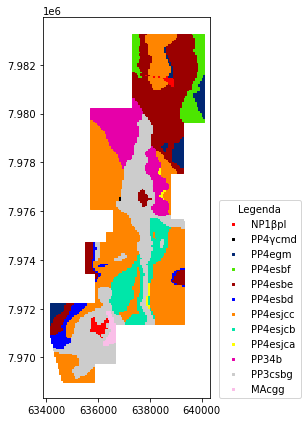

In [234]:
fig, ax = plt.subplots(figsize = (3,7))

ax.scatter(queryLithCoords(1, 'x'), queryLithCoords(1, 'y'), label=dic_lith[1][1],c="#ff0000", marker = 's', s = 2)
ax.scatter(queryLithCoords(2, 'x'), queryLithCoords(2, 'y'), label=dic_lith[2][1],c="#000000", marker = 's', s = 2)
ax.scatter(queryLithCoords(3, 'x'), queryLithCoords(3, 'y'), label=dic_lith[3][1],c="#002673", marker = 's', s = 2)
ax.scatter(queryLithCoords(4, 'x'), queryLithCoords(4, 'y'), label=dic_lith[4][1],c="#4ce600", marker = 's', s = 2)
ax.scatter(queryLithCoords(5, 'x'), queryLithCoords(5, 'y'), label=dic_lith[5][1],c="#9b0000", marker = 's', s = 2)
ax.scatter(queryLithCoords(6, 'x'), queryLithCoords(6, 'y'), label=dic_lith[6][1],c="#0000ff", marker = 's', s = 2)
ax.scatter(queryLithCoords(7, 'x'), queryLithCoords(7, 'y'), label=dic_lith[7][1],c="#ff8500", marker = 's', s = 2)
ax.scatter(queryLithCoords(8, 'x'), queryLithCoords(8, 'y'), label=dic_lith[8][1],c="#00e6a9", marker = 's', s = 2)
ax.scatter(queryLithCoords(9, 'x'), queryLithCoords(9, 'y'), label=dic_lith[9][1],c="#ffff00", marker = 's', s = 2)
ax.scatter(queryLithCoords(10, 'x'), queryLithCoords(10, 'y'), label=dic_lith[10][1],c="#e600a9", marker = 's', s = 2)
ax.scatter(queryLithCoords(11, 'x'), queryLithCoords(11, 'y'), label=dic_lith[11][1],c="#cccccc", marker = 's', s = 2)
ax.scatter(queryLithCoords(12, 'x'), queryLithCoords(12, 'y'), label=dic_lith[12][1],c="#fabee8", marker = 's', s = 2)

plt.legend(loc=(1.05,0.0), title = "Legenda");

##### Mapas das features

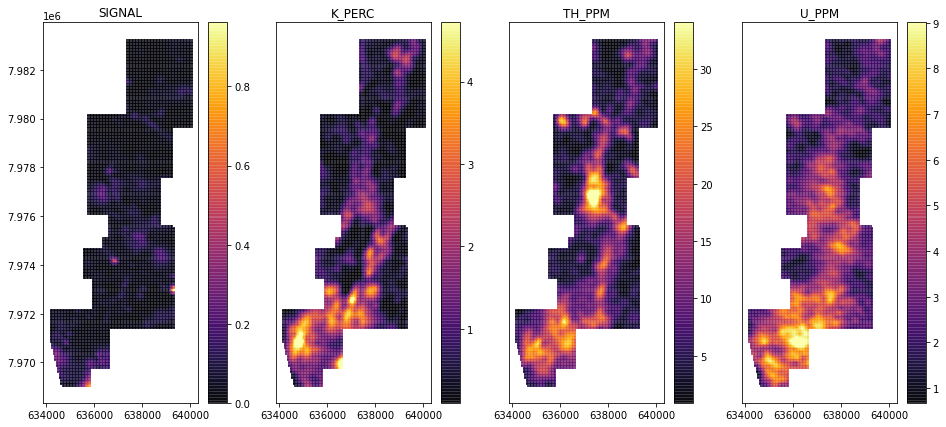

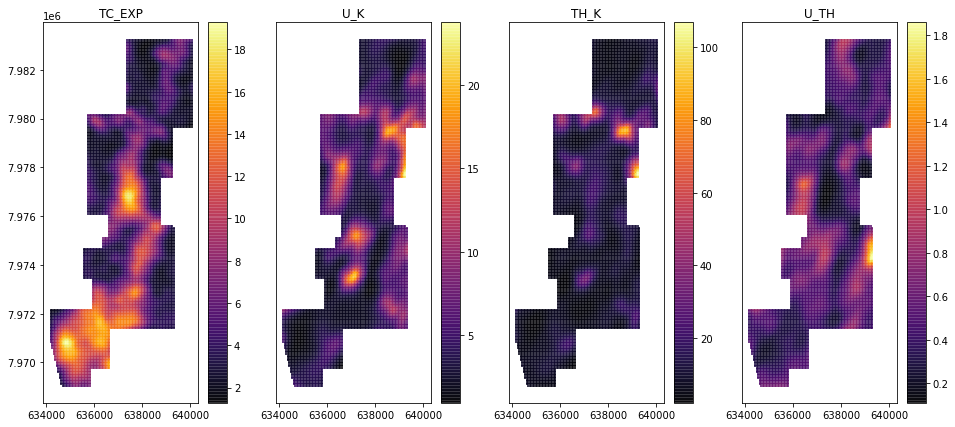

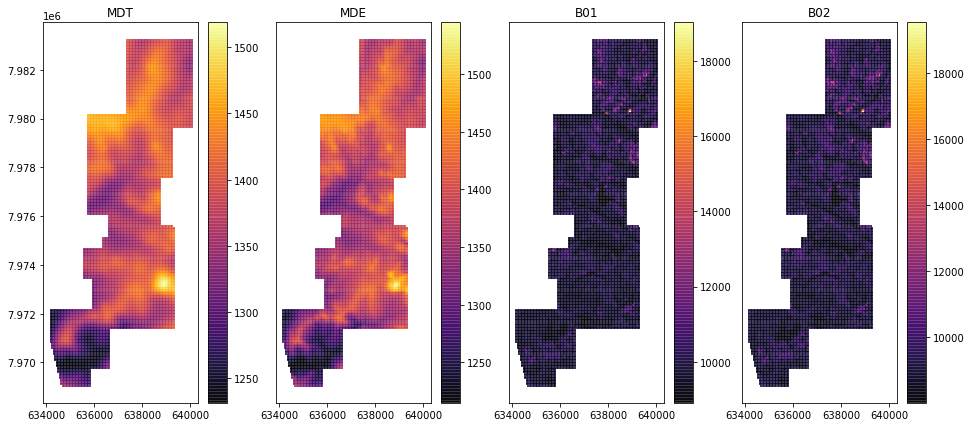

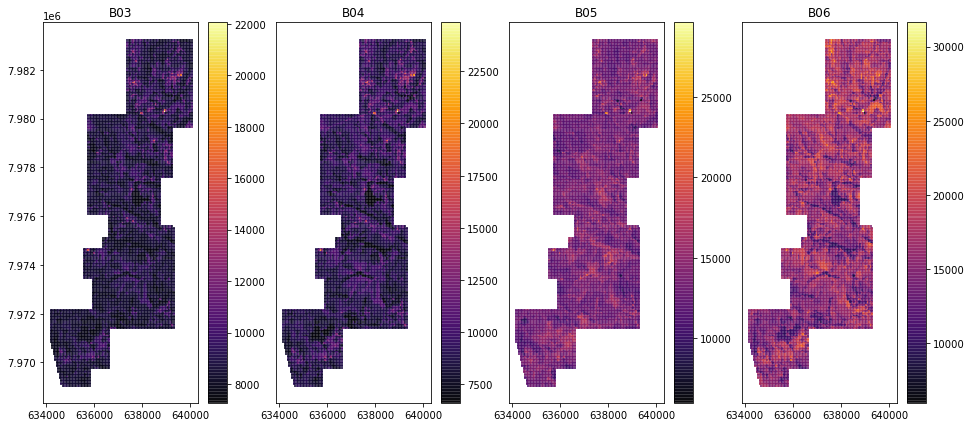

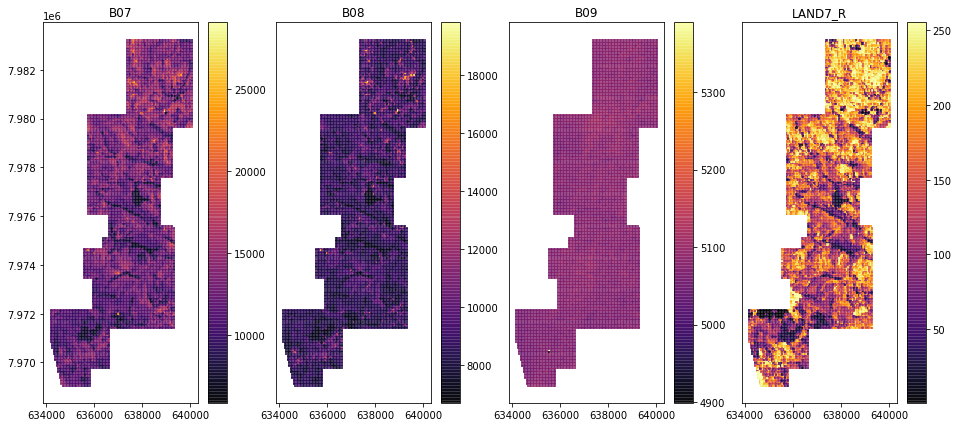

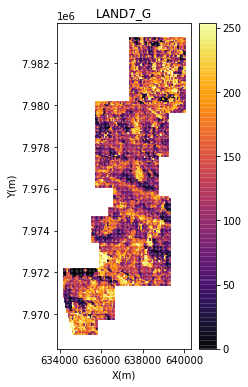

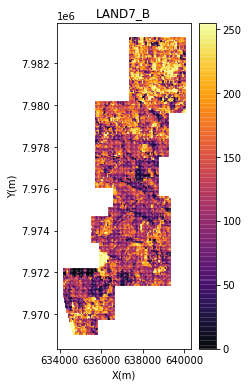

In [232]:
create4Maps(cols = feat[:4])
create4Maps(cols = feat[4:8])
create4Maps(cols = feat[8:12])
create4Maps(cols = feat[12:16])
create4Maps(cols = feat[16:20])
createMaps(col = 'LAND7_G')
createMaps(col = 'LAND7_B')

### Descrição univariada

##### Estatísticas dos dados geofísicos

In [141]:
sumStats(df = df[gf])

,X̅,50%,Min,10%,99.5%,Max,Amp,S²,S,Cᵥ,Skew
SIGNAL,0.048625,0.033145,0.000000,0.011728,0.272914,0.962399,0.962399,0.002544,0.050442,1.037373,4.250229
K_PERC,1.019616,0.640000,0.102035,0.190000,4.718372,4.719150,4.617115,0.910206,0.954047,0.935692,1.461631
TH_PPM,9.012547,6.450000,0.904060,2.600000,34.057678,34.077900,33.173840,49.000155,7.000011,0.776696,1.235449
U_PPM,3.428294,2.945000,0.680000,1.520000,9.008372,9.009150,8.329150,3.184647,1.784558,0.520538,0.838544
TC_EXP,6.370295,4.930000,1.280000,2.460000,17.220000,19.280000,18.000000,15.867890,3.983452,0.625317,0.877143
U_K,5.380546,4.420000,0.970000,2.120000,18.119150,23.730000,22.760000,11.518617,3.393909,0.630774,1.518701
TH_K,12.626573,9.840000,2.230000,5.310000,74.419150,106.870000,104.640000,105.673929,10.279783,0.814139,3.621432
U_TH,0.479001,0.450000,0.110000,0.270000,1.290000,1.860000,1.750000,0.040191,0.200478,0.418534,1.401608


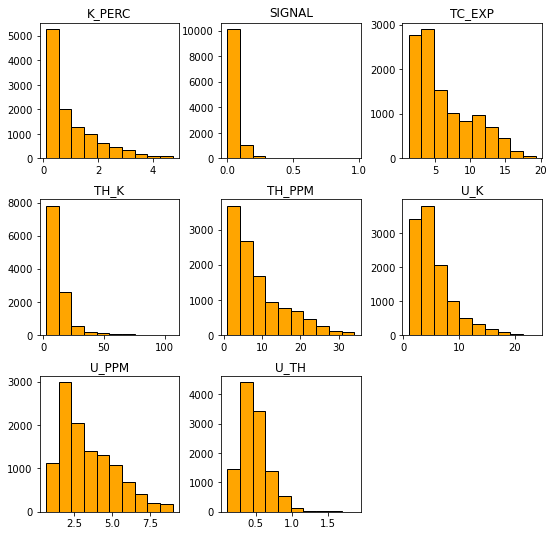

In [186]:
df[gf].hist(edgecolor='black', color='orange', figsize=(9,9), grid=False);

- Todas as features geofísicas apresentam distribuições assimétricas positivas;

- As features geofísicas tendem a ser as mais erráticas do banco de dados, com destaque para `SIGNAL` que, por sua vez, apresenta um Cᵥ ~ 1.04.

##### Estatísticas dos sensores remotos

In [142]:
sumStats(df = df[sr])

,X̅,50%,Min,10%,99.5%,Max,Amp,S²,S,Cᵥ,Skew
MDT,1376.713832,1383.765,1231.48,1309.447,1481.67555,1518.86,287.38,2.383816e+03,48.824333,0.035464,-0.751587
MDE,1371.491067,1379.000,1215.00,1299.000,1480.91500,1545.00,330.00,2.662541e+03,51.599815,0.037623,-0.781676
B01,9789.359345,9680.000,8905.00,9301.000,12100.06500,19037.00,10132.00,2.688853e+05,518.541536,0.052970,2.704648
B02,9127.988965,9012.000,8010.00,8523.000,11752.83000,19540.00,11530.00,3.767398e+05,613.791292,0.067243,2.429767
B03,8805.247154,8656.000,7272.00,8004.000,12105.57500,22051.00,14779.00,6.268228e+05,791.721443,0.089915,2.342953
B04,9057.911105,8924.000,6613.00,7781.700,13584.02500,24846.00,18233.00,1.360990e+06,1166.614752,0.128795,1.555522
B05,13390.707304,13203.000,5960.00,11855.000,17983.66000,29667.00,23707.00,2.014171e+06,1419.215064,0.105985,0.912569
B06,15849.828254,15917.500,5962.00,12605.400,22480.51500,31637.00,25675.00,6.095484e+06,2468.903304,0.155768,-0.011219
B07,12359.669207,12247.000,5885.00,9496.500,19146.06500,29052.00,23167.00,5.197637e+06,2279.832696,0.184457,0.312071
B08,8833.474864,8675.500,6703.00,7789.000,13067.70500,19822.00,13119.00,1.002425e+06,1001.211582,0.113343,2.106471


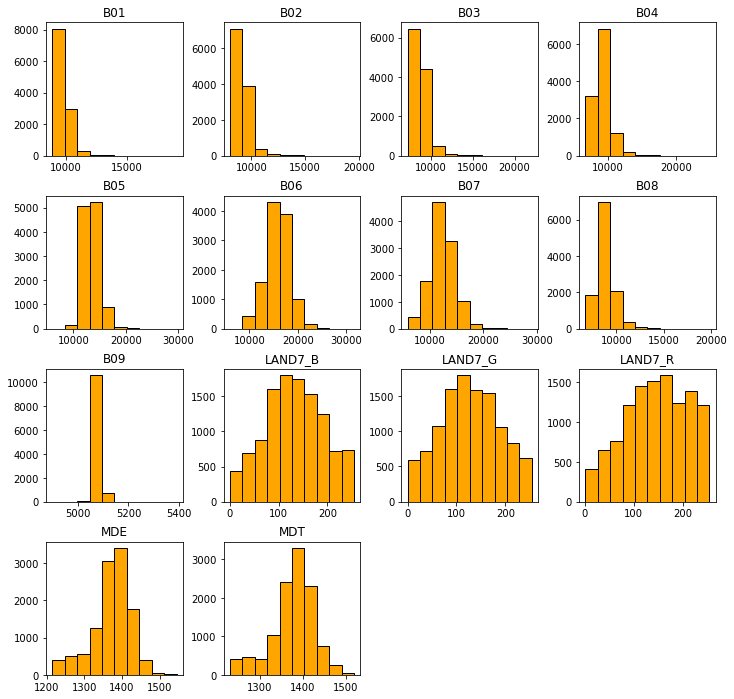

In [217]:
df[sr].hist(edgecolor='black', color='orange', figsize=(12,12), grid=False);

- A grande maioria dos sensores remotos apresentam distribuições assimétricas positivas ou quase simétricas;

- Apenas três features apresentam distribuições assimétricas negativas: `MDE`, `MDT` e `LAND7_R`.

- Em geral, os sensores remotos tendem a ser pouco erráticos, com destaque para `B09` que, por sua vez, apresenta um Cᵥ ~ 0.03.

##### Análise da dispersão das features

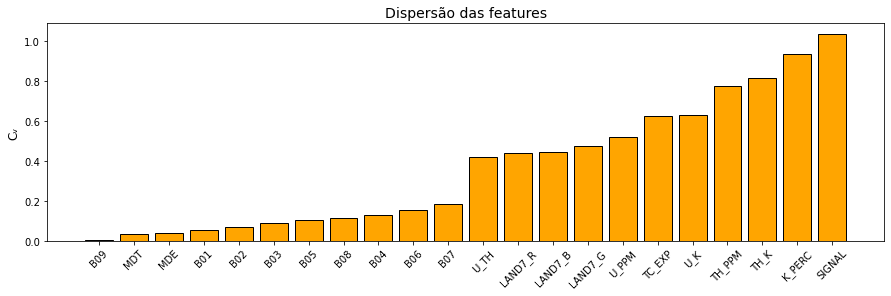

In [189]:
plt.figure(figsize=(15,4))

plt.bar(x = disp.index, height = disp.values,
       color = "orange", edgecolor = "black")

plt.title("Dispersão das features",size = 14)
plt.xticks(rotation = 45)
plt.ylabel("Cᵥ",size = 12);

- Os sensores remotos tendem a ser muito pouco erráticos (Cᵥ < 0.2), com exceção das features `LAND7_R`, `LAND7_G` e `LAND7_B` que, por sua vez, encontram-se entre as 10 features mais erráticas;

- Os dados geofísicos são, em geral os que apresentam maior dispersão, com exceção da razão `U_TH`.

##### Gráfico de barras unidades litoestratigráficas

In [163]:
# Criação de dataframe com as variáveis utilizadas nos gráfico
df_lito_count = pd.DataFrame(df['UNID'].value_counts()) # Criação do dataframe
total_lito_count = df['UNID'].value_counts().sum() # Contagem total
df_lito_count['UNID_PERC'] = (df_lito_count['UNID'] / total_lito_count) * 100 # Criação de coluna de frequência percentual
freq_abs = df_lito_count['UNID'] # Variável de frequência absoluta
freq_perc = df_lito_count['UNID_PERC'].round(2) # Variável de frequência percentual

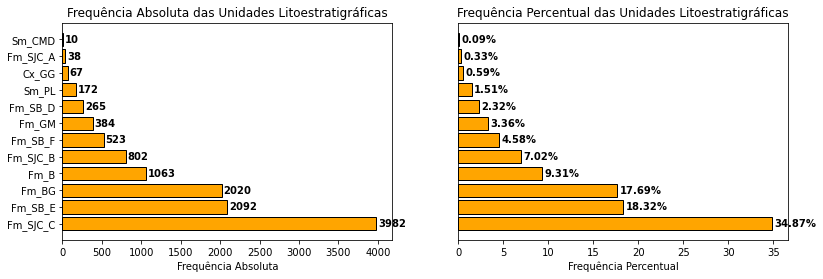

In [166]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,4))

# Gráfico frequência absoluta
ax1.barh(list(df_lito_count.index),
         freq_abs,
         color='orange',
         edgecolor='black')

for i, v in enumerate(freq_abs):
    ax1.text(v + 20, i, str(v), va='center', fontweight='bold')
    
plt.setp(ax1,title="Frequência Absoluta das Unidades Litoestratigráficas",
         xlabel="Frequência Absoluta")


# Gráfico frequência percentual
ax2.barh(list(df_lito_count.index),
         freq_perc,
         color='orange',
         edgecolor='black')

ax2.axes.get_yaxis().set_visible(False)

for i, v in enumerate(freq_perc):
    ax2.text(v + 0.25, i, str(v) + "%", va='center', fontweight='bold')
    
plt.setp(ax2,title="Frequência Percentual das Unidades Litoestratigráficas",
         xlabel="Frequência Percentual");

- As 3 unidades litoestratigráficas mais frequentes (`Fm_SJC_C`, `Fm_SB_E` e `Fm_BG`) representam mais de 70% do total de ocorrências;

- Portanto, as classes estão claramente desbalanceadas e algumas abordagens serão conduzidas posteriormente para lidar com esse problema.

### Descrição Bivariada

##### Mapas de calor - coeficiente de correlação de Spearman

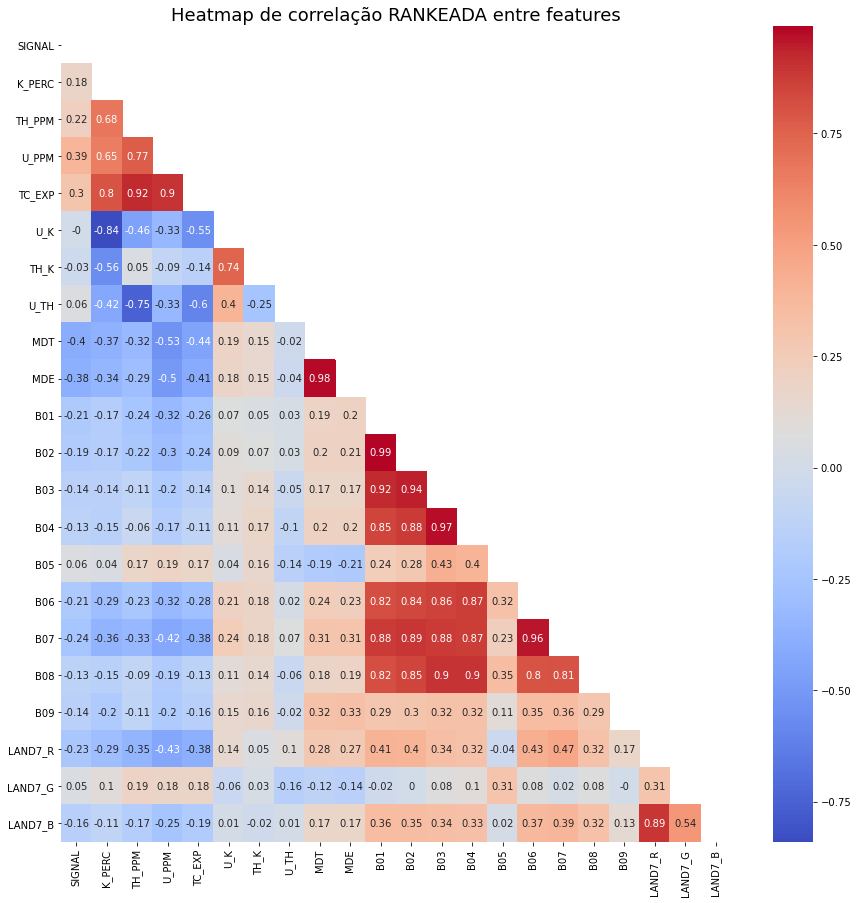

In [193]:
mx_spear = df[feat].corr(method='spearman').round(2)

mask = np.triu(np.ones_like(mx_spear, dtype=np.bool))

plt.figure(figsize=(15, 15))
plt.title ('Heatmap de correlação RANKEADA entre features', size=18)
ax = sns.heatmap(
                 mx_spear,
                 annot = True,
                 cmap = "coolwarm",
                 cbar = True,
                 mask=mask
                )

##### Mapas de calor - Coeficiente de Correlação de Pearson

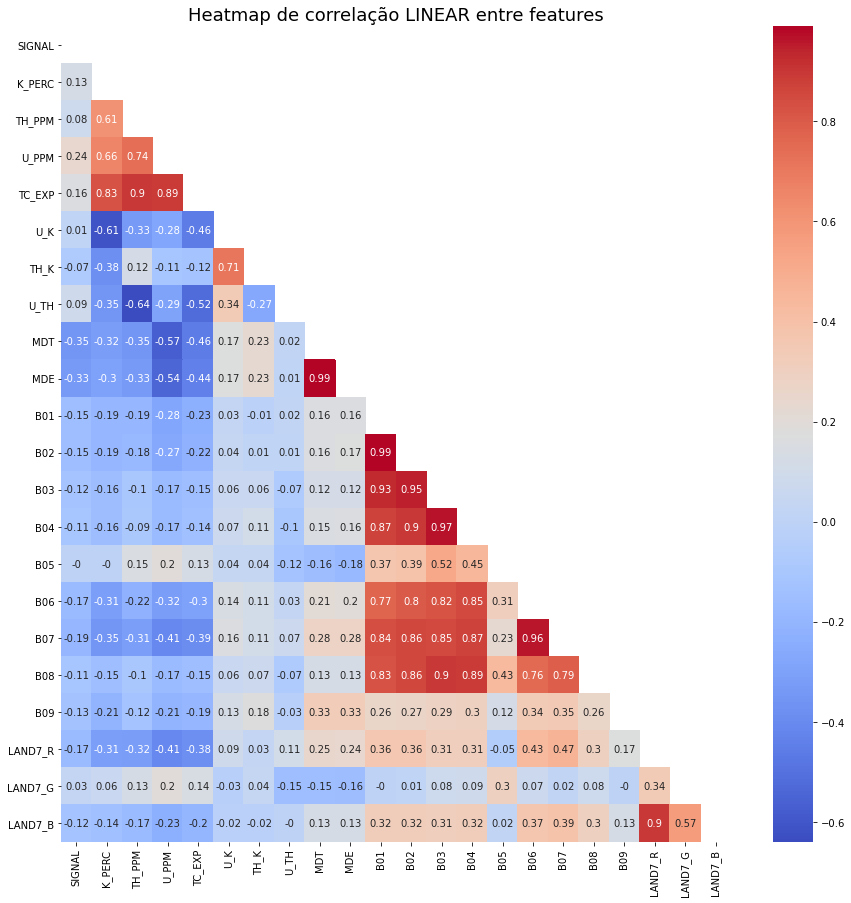

In [194]:
mx_pear = df[feat].corr().round(2)

mask = np.triu(np.ones_like(mx_pear, dtype=np.bool))

plt.figure(figsize=(15, 15))
plt.title ('Heatmap de correlação LINEAR entre features', size=18)
ax = sns.heatmap(
                 mx_pear,
                 annot = True,
                 cmap = "coolwarm",
                 cbar = True,
                 mask=mask
                )

- As features `U_PPM`, `TH_PPM` e `K_PERC` apresentam correlações lineares positivas médias a fortes entre si;

- As features `U_PPM`, `TH_PPM` e `K_PERC` apresentam forte correlação linear positiva com a variável `TC_EXP`, o que já era esperado;

- A feature `SIGNAL` não apresenta correlação (linear ou monotônica) significativa com nenhuma outra feature;

- As features Landsat 8 apresentam fortíssimas correlações lineares entre si. Esse fato pode implicar em multicolinearidade e deve ser tratado cautelosamente caso um algoritmo linear seja utilizado.As únicas exceções são `B05` e `B09`;

- As features `MDE` e `MDT` são particamente idênticas. Apenas uma delas deve ser selecionada para treinar os algoritmos;

- A feature `MDT` apresenta uma correlação linear negativa média com `U_PPM`. Esse fato é interessante e deve ser investigado!

##### Features geofísicas x target

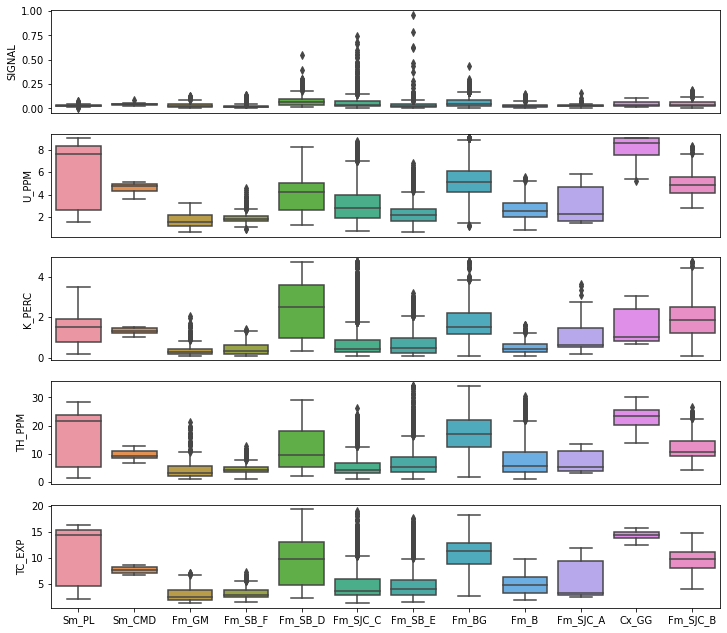

In [198]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,figsize=(12,11))

sns.boxplot(y='SIGNAL', x='UNID', data=df, ax=ax1)
sns.boxplot(y='U_PPM', x='UNID', data=df, ax=ax2)
sns.boxplot(y='K_PERC', x='UNID', data=df, ax=ax3)
sns.boxplot(y='TH_PPM', x='UNID', data=df, ax=ax4)
sns.boxplot(y='TC_EXP', x='UNID', data=df, ax=ax5)

plt.setp((ax1,ax2,ax3,ax4, ax5), xlabel='')
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax3.axes.get_xaxis().set_visible(False)
ax4.axes.get_xaxis().set_visible(False);

##### Features Landsat 8 x target

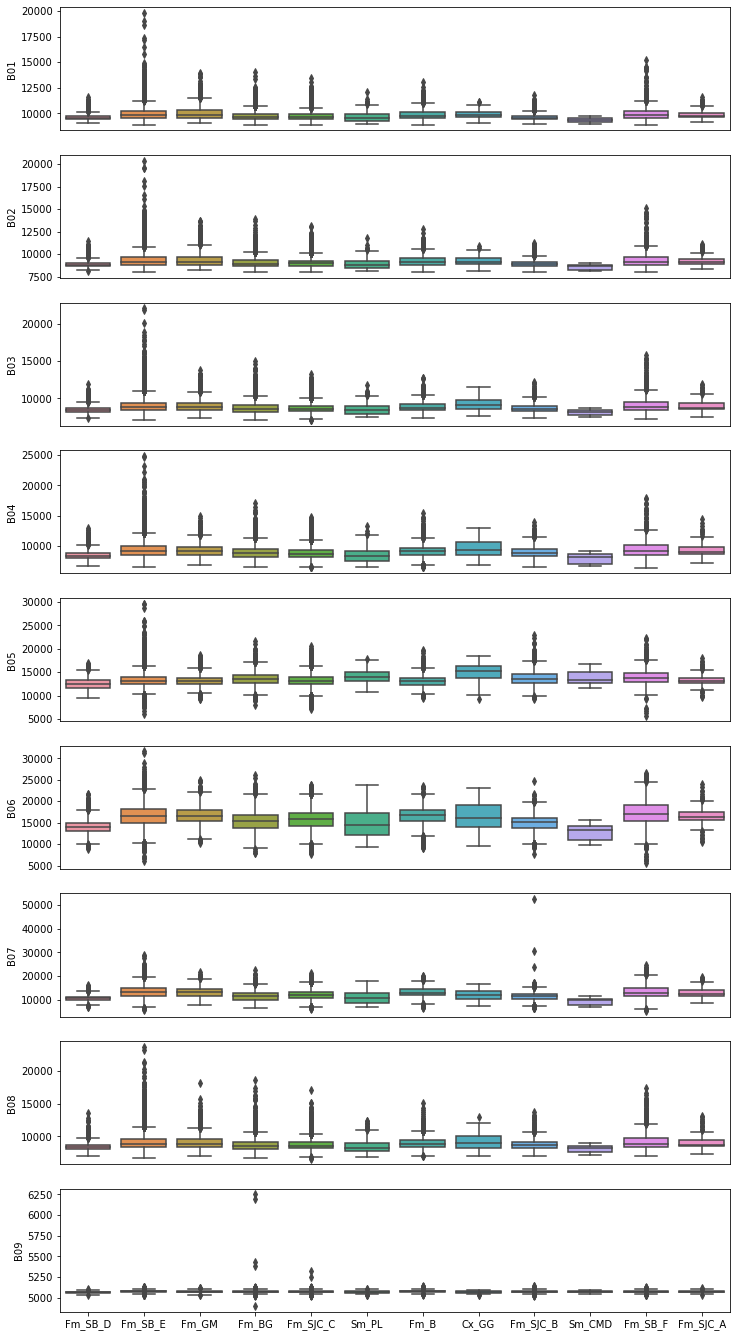

In [27]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9) = plt.subplots(9,1,figsize=(12,24))

sns.boxplot(x='UNID', y='B01', data=df, ax=ax1)
sns.boxplot(x='UNID', y='B02', data=df, ax=ax2)
sns.boxplot(x='UNID', y='B03', data=df, ax=ax3)
sns.boxplot(x='UNID', y='B04', data=df, ax=ax4)
sns.boxplot(x='UNID', y='B05', data=df, ax=ax5)
sns.boxplot(x='UNID', y='B06', data=df, ax=ax6)
sns.boxplot(x='UNID', y='B07', data=df, ax=ax7)
sns.boxplot(x='UNID', y='B08', data=df, ax=ax8)
sns.boxplot(x='UNID', y='B09', data=df, ax=ax9)

plt.setp((ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9), xlabel='')
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax3.axes.get_xaxis().set_visible(False)
ax4.axes.get_xaxis().set_visible(False)
ax5.axes.get_xaxis().set_visible(False)
ax6.axes.get_xaxis().set_visible(False)
ax7.axes.get_xaxis().set_visible(False)
ax8.axes.get_xaxis().set_visible(False);

##### Outros sensores remotos x features

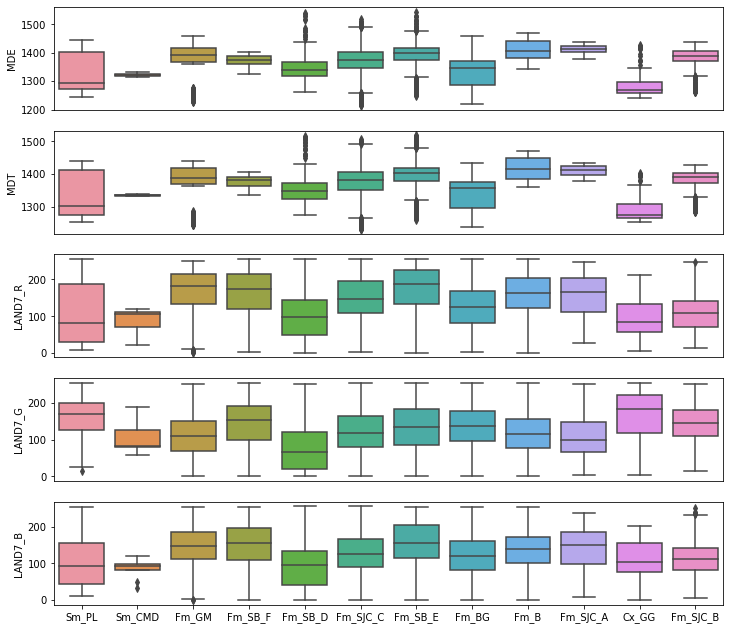

In [201]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,figsize=(12,11))

sns.boxplot(y='MDE', x='UNID', data=df, ax=ax1)
sns.boxplot(y='MDT', x='UNID', data=df, ax=ax2)
sns.boxplot(y='LAND7_R', x='UNID', data=df, ax=ax3)
sns.boxplot(y='LAND7_G', x='UNID', data=df, ax=ax4)
sns.boxplot(y='LAND7_B', x='UNID', data=df, ax=ax5)

plt.setp((ax1,ax2,ax3,ax4, ax5), xlabel='')
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax3.axes.get_xaxis().set_visible(False)
ax4.axes.get_xaxis().set_visible(False);

- As features Landsat 8 apresentam uma variabilidade extremamente baixa quando agrupadas por unidades litoestratigráficas. Nesse sentido, possivelmente, essas variáveis não serão úteis para treinar os modelos;

- Em contrapartida, as features geofísicas, juntamente com `MDE` / `MDT`, `LAND7_R`, `LAND7_G` e `LAND7_B`, apresentam uma dispersão significativa quando agrupadas pelas unidades. Essas variáveis possivelmente contribuirão positivamente para as predições.

##### Estatísticas de K (%) por unidade litoestratigráfica

In [199]:
df[['UNID', 'K_PERC']].groupby(by='UNID').describe(percentiles=[0.1,0.995]).T

UNID              Cx_GG         Fm_B        Fm_BG       Fm_GM     Fm_SB_D  \
K_PERC count  67.000000  1063.000000  2020.000000  384.000000  265.000000   
       mean    1.530149     0.506757     1.729954    0.379748    2.446235   
       std     0.809286     0.263806     0.878516    0.325887    1.403461   
       min     0.670000     0.102035     0.102035    0.102035    0.320000   
       10%     0.710000     0.210000     0.800000    0.110000    0.568000   
       50%     1.050000     0.450000     1.520000    0.270000    2.520000   
       99.5%   2.990400     1.417600     4.719150    1.739550    4.719150   
       max     3.030000     1.640000     4.719150    2.060000    4.719150   

UNID              Fm_SB_E     Fm_SB_F   Fm_SJC_A    Fm_SJC_B     Fm_SJC_C  \
K_PERC count  2092.000000  523.000000  38.000000  802.000000  3982.000000   
       mean      0.714696    0.432153   1.232105    1.897234     0.793884   
       std       0.636324    0.310973   0.972995    1.031912     0.869994   
       min       0.102035    0.102035   0.170000    0.102035     0.102035   
       10%       0.130000    0.110000   0.437000    0.391000     0.180000   
       50%       0.490000    0.320000   0.610000    1.850000     0.440000   
       99.5%     2.820000    1.341700   3.611500    4.719150     4.612850   
       max       3.180000    1.400000   3.630000    4.719150     4.719150   

UNID             Sm_CMD       Sm_PL  
K_PERC count  10.000000  172.000000  
       mean    1.323000    1.442733  
       std     0.159308    0.821266  
       min     1.040000    0.210000  
       10%     1.139000    0.321000  
       50%     1.340000    1.520000  
       99.5%   1.499100    3.418700  
       max     1.500000    3.470000

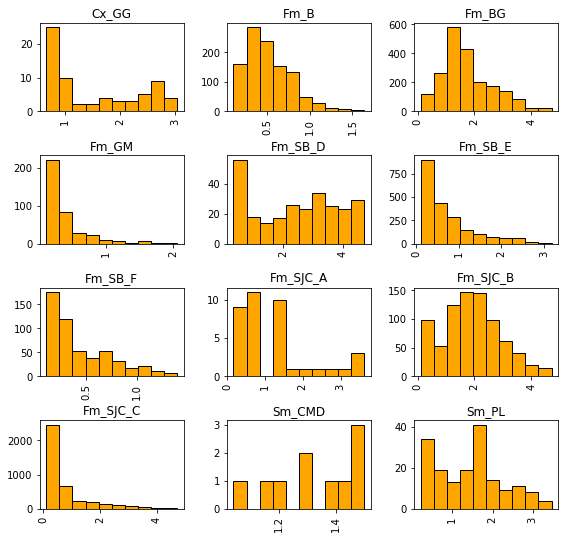

In [205]:
df['K_PERC'].hist(by=df['UNID'], figsize=(9, 9), edgecolor='black', color='orange');

- As unidades que apresentam MAIORES concentrações de `K_PERC` são **Fm_SB_D** e **Fm_SJC_B**;

- As unidades que apresentam MENORES concentrações de `K_PERC` são **Fm_GM** e **Fm_SB_F**.

##### Estatísticas de U (ppm) por unidade litoestratigráfica

In [30]:
df[['UNID', 'U_PPM']].groupby(by='UNID').describe(percentiles=[0.1,0.9]).T

UNID              Cx_GG         Fm_B        Fm_BG        Fm_GM      Fm_SB_D  \
U_PPM count  284.000000  4518.000000  8763.000000  1558.000000  1169.000000   
      mean     8.356824     2.693106     5.208569     1.712720     4.049709   
      std      1.272972     0.932242     1.413158     0.634278     1.591074   
      min      5.327177     0.832672     1.271856     0.688030     1.319856   
      10%      6.169685     1.592586     3.490547     0.934873     1.624904   
      50%      8.692089     2.551557     5.140765     1.604350     4.201321   
      90%      9.843404     4.004812     6.966806     2.679447     6.146801   
      max     10.718714     5.594017    10.746654     3.247084     8.179647   

UNID             Fm_SB_E      Fm_SB_F    Fm_SJC_A     Fm_SJC_B      Fm_SJC_C  \
U_PPM count  9074.000000  2253.000000  169.000000  3425.000000  17167.000000   
      mean      2.335405     1.959729    3.233520     4.962629      3.128945   
      std       0.921712     0.477942    1.627969     0.998789      1.546543   
      min       0.683188     1.009492    1.499944     2.900385      0.775729   
      10%       1.441414     1.456406    1.557168     3.758673      1.444859   
      50%       2.164170     1.886133    2.277743     4.858009      2.788145   
      90%       3.348301     2.518543    5.400302     6.285145      5.408681   
      max       6.785595     4.573975    5.786976     8.333800      8.690520   

UNID            Sm_CMD       Sm_PL  
U_PPM count  43.000000  728.000000  
      mean    4.687608    6.068645  
      std     0.375794    2.872114  
      min     3.722484    1.566658  
      10%     4.083611    2.097044  
      50%     4.851083    7.630196  
      90%     5.006223    8.738074  
      max     5.076655   10.418007

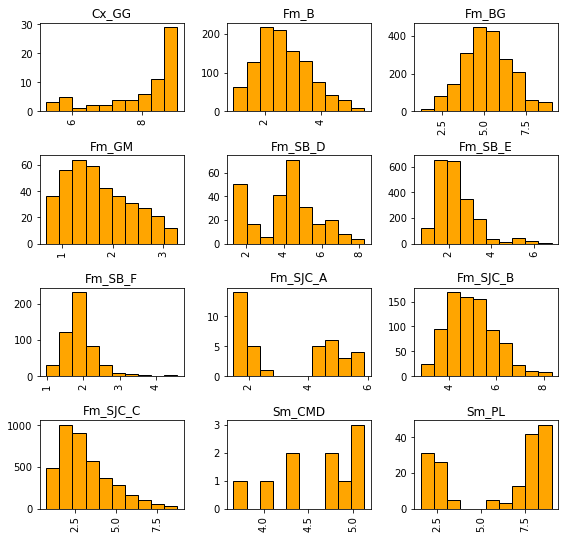

In [204]:
df['U_PPM'].hist(by=df['UNID'], figsize=(9, 9), edgecolor='black', color='orange');

- As unidades que apresentam MAIORES concentrações de `U_PPM` são **Cx_GG** e **Fm_BG**;

- As unidades que apresentam MENORES concentrações de `U_PPM` são **Fm_GM** e **Fm_SB_F**.

##### Estatísticas de Th (ppm) por unidade litoestratigráfica

In [32]:
df[['UNID', 'TH_PPM']].groupby(by='UNID').describe(percentiles=[0.1,0.9]).T

UNID               Cx_GG         Fm_B        Fm_BG        Fm_GM      Fm_SB_D  \
TH_PPM count  284.000000  4518.000000  8763.000000  1558.000000  1169.000000   
       mean    23.845410     7.909446    17.552148     4.625522    11.675192   
       std      3.418433     5.904942     7.331523     3.822767     7.240446   
       min     14.867985     0.511843     1.611850     0.492094     2.042245   
       10%     19.051635     2.361451     9.130134     1.507737     3.701219   
       50%     24.211368     5.760395    17.092914     3.466688     9.166050   
       90%     28.339158    16.826116    26.946860     8.373490    22.703736   
       max     29.885514    29.838185    46.539405    21.312994    28.479071   

UNID              Fm_SB_E      Fm_SB_F    Fm_SJC_A     Fm_SJC_B      Fm_SJC_C  \
TH_PPM count  9074.000000  2253.000000  169.000000  3425.000000  17167.000000   
       mean      7.097527     4.834922    7.892128    12.083574      5.720799   
       std       5.092387     2.092756    4.566499     4.292540      4.166544   
       min       0.802953     0.889807    2.843787     3.875294      0.208261   
       10%       2.836066     2.831087    3.196220     8.074988      2.135162   
       50%       5.567178     4.327227    4.918016    10.500468      4.307302   
       90%      12.615289     7.785694   13.921217    19.340043     10.844682   
       max      42.231350    12.924556   16.309874    25.635160     25.728865   

UNID             Sm_CMD       Sm_PL  
TH_PPM count  43.000000  728.000000  
       mean    8.904993   16.319349  
       std     1.800450    9.250525  
       min     5.916132    1.074324  
       10%     6.787572    2.704698  
       50%     8.667284   21.642467  
       90%    11.397100   24.530428  
       max    13.132428   28.373244

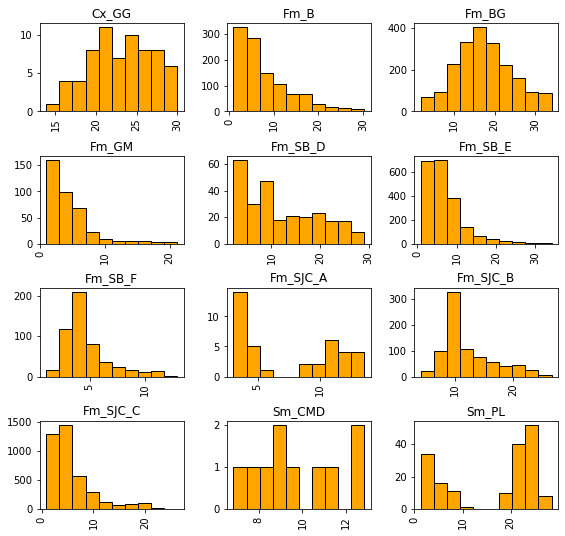

In [206]:
df['TH_PPM'].hist(by=df['UNID'], figsize=(9, 9), edgecolor='black', color='orange');

- As unidades que apresentam MAIORES concentrações de `TH_PPM` são **Cx_GG** e **Fm_BG** (mesmas do `U_PPM`);

- As unidades que apresentam MENORES concentrações de `TH_PPM` são **Fm_GM** e **Fm_SB_F** (mesmas do `U_PPM`).

##### Estatísticas de contagem total (μR/h) por unidade litoestratigráfica

In [34]:
df[['UNID', 'TC_EXP']].groupby(by='UNID').describe(percentiles=[0.1,0.9]).T

UNID               Cx_GG         Fm_B        Fm_BG        Fm_GM      Fm_SB_D  \
TC_EXP count  284.000000  4518.000000  8763.000000  1558.000000  1169.000000   
       mean    14.573908     4.915378    10.869561     3.009959     9.505110   
       std      0.674758     1.961258     3.118323     1.355698     4.669157   
       min     12.828207     1.814645     2.711959     1.327494     2.219104   
       10%     13.587334     2.462336     6.702045     1.568365     3.177558   
       50%     14.703404     4.736930    11.251474     2.532169     9.784268   
       90%     15.378579     7.717443    14.863123     5.050615    16.321726   
       max     15.790096    10.213819    18.596657     7.029311    19.200745   

UNID              Fm_SB_E      Fm_SB_F    Fm_SJC_A     Fm_SJC_B      Fm_SJC_C  \
TC_EXP count  9074.000000  2253.000000  169.000000  3425.000000  17167.000000   
       mean      4.645993     3.316257    6.271436     9.541953      4.956989   
       std       2.482097     1.111707    3.737952     2.323494      3.196096   
       min       1.543792     1.517986    2.273154     3.810248      1.417397   
       10%       2.449416     2.261034    2.675581     6.146612      2.380452   
       50%       4.018648     2.902984    3.300178     9.782187      3.672803   
       90%       6.939843     5.025424   11.509131    12.331877     10.696831   
       max      18.092209     7.301918   12.626494    14.689779     19.110498   

UNID             Sm_CMD       Sm_PL  
TC_EXP count  43.000000  728.000000  
       mean    7.349146   10.871034  
       std     0.574106    5.414941  
       min     6.390284    2.143025  
       10%     6.597854    2.712959  
       50%     7.293442   14.208142  
       90%     8.144618   15.719456  
       max     8.476452   16.399777

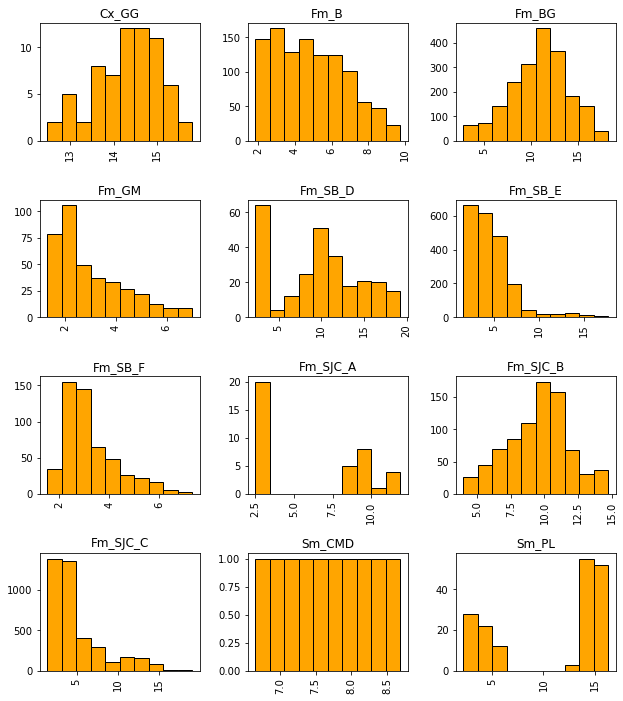

In [207]:
df['TC_EXP'].hist(by=df['UNID'], figsize=(10, 12), edgecolor='black', color='orange');

- As unidades que apresentam MAIORES concentrações de `TC_EXP` são **Cx_GG** e **Fm_BG** (mesmas do `U_PPM` e `TH_PPM`);

- As unidades que apresentam MENORES concentrações de `TC_EXP` são **Fm_GM** e **Fm_SB_F** (mesmas do `U_PPM` e `TH_PPM`);

- OBS.: a distribuição uniforme apresentada por **Sm_CMD** ocorre em função da baixa densidade amostral dessa unidade (10 valores e 10 *bins*).

##### Estatísticas de sinal análitico (nT/m) por unidade litoestratigráfica

In [212]:
df[['UNID', 'SIGNAL']].groupby(by='UNID').describe(percentiles=[0.1,0.9]).T

UNID              Cx_GG         Fm_B        Fm_BG       Fm_GM     Fm_SB_D  \
SIGNAL count  67.000000  1063.000000  2020.000000  384.000000  265.000000   
       mean    0.043463     0.030320     0.061803    0.029581    0.083216   
       std     0.026423     0.023523     0.051433    0.024113    0.070785   
       min     0.012960     0.001470     0.001725    0.003204    0.008845   
       10%     0.018700     0.010169     0.014981    0.007671    0.027161   
       50%     0.036008     0.023046     0.046121    0.020791    0.061637   
       90%     0.084432     0.060273     0.137179    0.055687    0.168886   
       max     0.105082     0.144330     0.437557    0.129563    0.550258   

UNID              Fm_SB_E     Fm_SB_F   Fm_SJC_A    Fm_SJC_B     Fm_SJC_C  \
SIGNAL count  2092.000000  523.000000  38.000000  802.000000  3982.000000   
       mean      0.036868    0.025665   0.036983    0.047027     0.056950   
       std       0.044899    0.023980   0.029665    0.031436     0.059477   
       min       0.001291    0.003913   0.004470    0.004734     0.000000   
       10%       0.011163    0.008551   0.015105    0.014868     0.012374   
       50%       0.025521    0.017815   0.026017    0.038828     0.037942   
       90%       0.072905    0.053147   0.069988    0.091113     0.117147   
       max       0.962399    0.142053   0.155228    0.190429     0.743154   

UNID             Sm_CMD       Sm_PL  
SIGNAL count  10.000000  172.000000  
       mean    0.045278    0.028506  
       std     0.014826    0.011342  
       min     0.028408    0.003918  
       10%     0.030325    0.016186  
       50%     0.042953    0.026073  
       90%     0.056717    0.044775  
       max     0.081434    0.076001

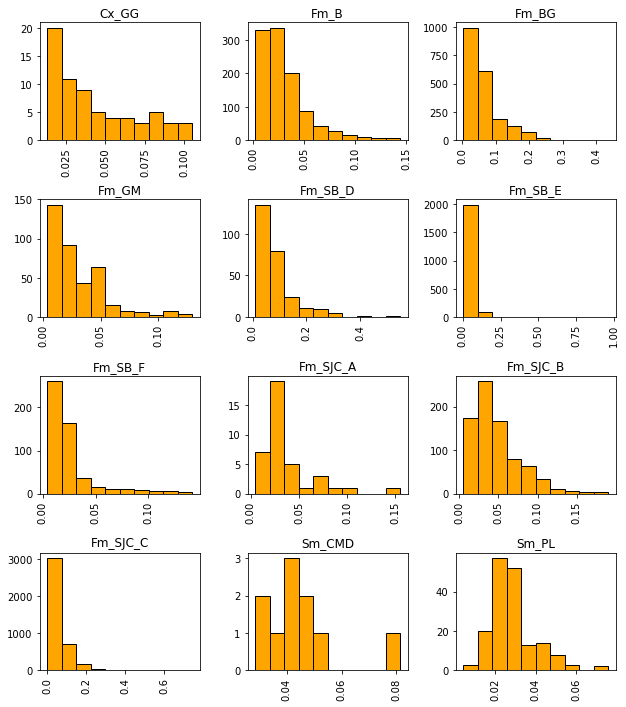

In [213]:
df['SIGNAL'].hist(by=df['UNID'], figsize=(10, 12), edgecolor='black', color='orange');

- As unidades que apresentam MAIORES concentrações de `SIGNAL` são **Fm_SB_D** e **Fm_BG**;

- As unidades que apresentam MENORES concentrações de `SIGNAL` são **Fm_SB_F** e **Sm_PL**.